# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import sys
import os
from math import sqrt
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


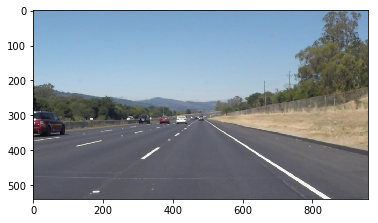

In [6]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [7]:
# moved to below


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
imgs_dir = 'test_images/'

os.listdir(imgs_dir)

['solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'exit-ramp.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).


 extra10.jpg

 extra8.jpg

 extra2.jpg

 extra3.jpg

 extra5.jpg

 extra7.jpg

 extra6.jpg

 extra1.jpg


/home/john/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



 extra9.jpg

 extra4.jpg


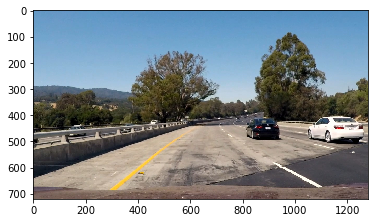

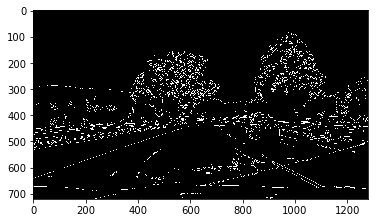

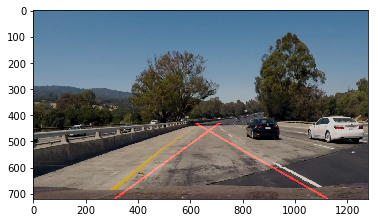

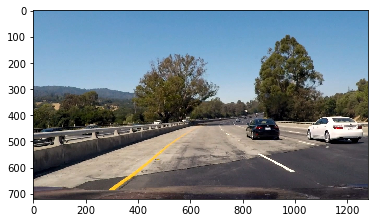

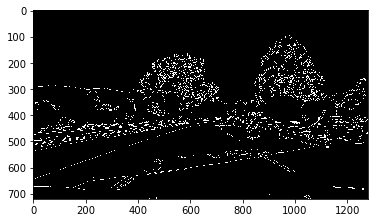

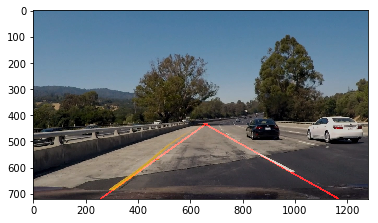

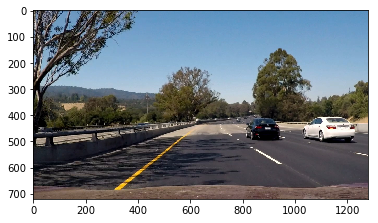

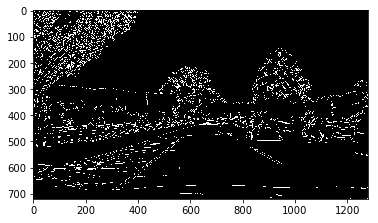

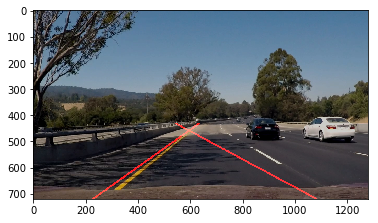

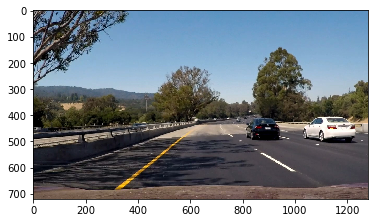

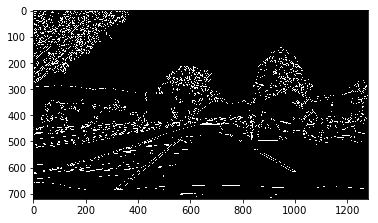

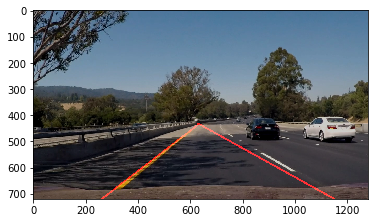

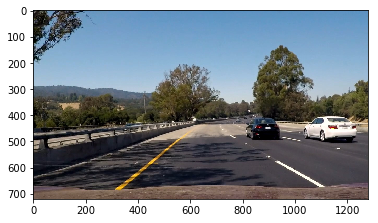

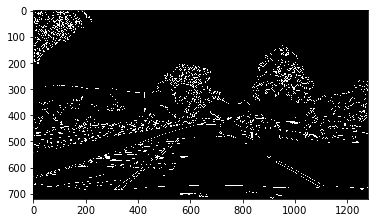

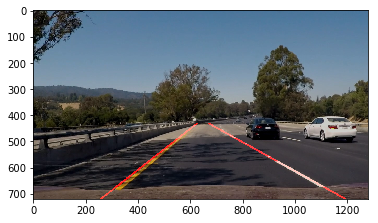

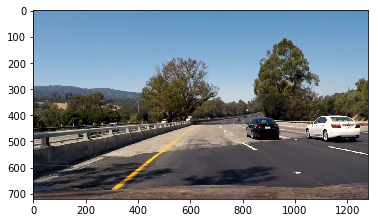

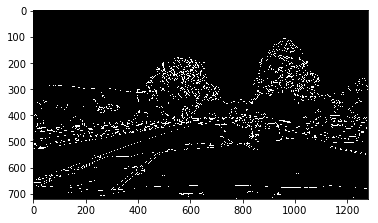

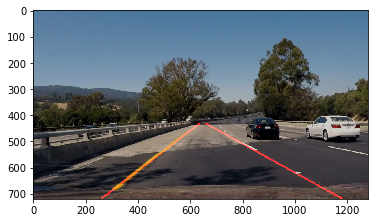

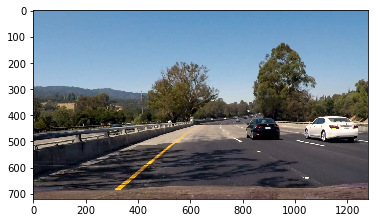

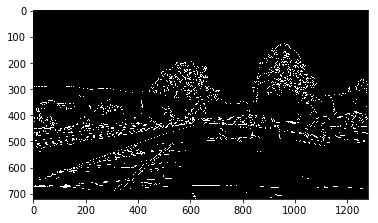

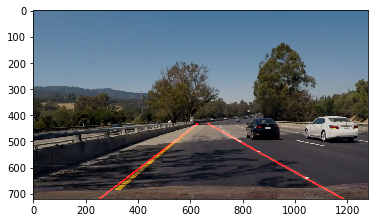

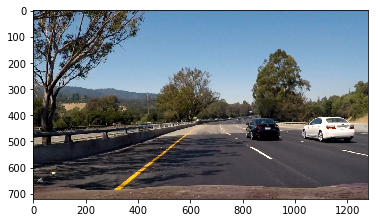

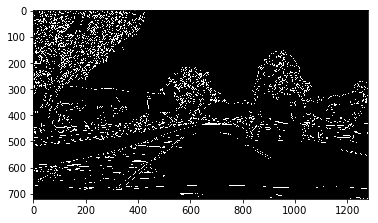

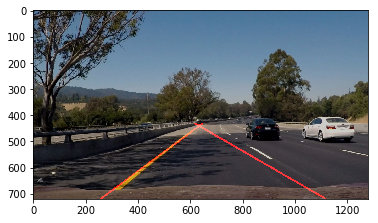

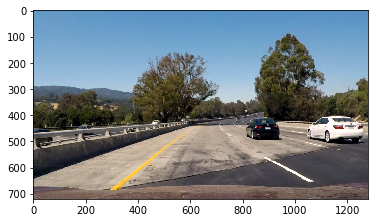

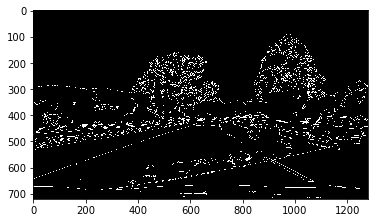

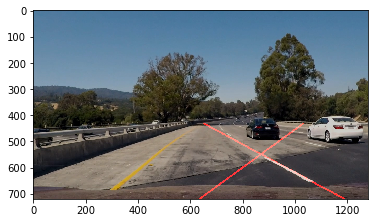

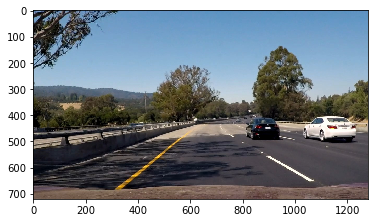

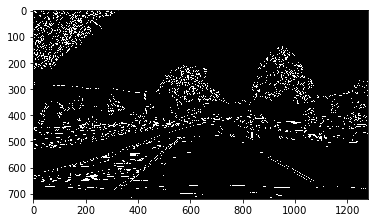

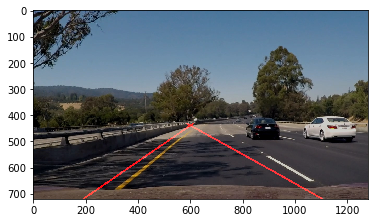

In [9]:
# Pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

yROIpct = .6 # % in y axis to start ROI
minslope = .4
maxslope = 4

def grayscale(image):
    """Read in image path and apply the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()

def canny(img, thres_low=30, thres_high=150, kernel_size=5):
    """Applies the Canny transform after a Gaussian blur"""
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return cv2.Canny(img, thres_low, thres_high)
    
def lanes_ROI_edges(img):
    """
    Applies a ROI image mask, keeping only the region of the image defined by the polygon
     formed from `vertices`. The rest of the image is set to black.
    """
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
          
    xlen = img.shape[1]
    ylen = img.shape[0]
    xmid = xlen // 2
    y = int(ylen * yROIpct)
    xoffset = xlen // 30
    vertices = np.array([[(0,ylen),(xmid-xoffset, y), (xmid+xoffset, y),(xlen,ylen)]], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    return cv2.bitwise_and(img, mask)

def draw_lines(image, lines, color=(255, 0, 0), thickness=5, multicolors=False):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255),(255,0,255)] if multicolors else [color]
    i = 0
    result = np.copy(image)*0 # creating a blank to draw lines on

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(result, (x1, y1), (x2, y2), colors[i], thickness)
            if multicolors:
                i += 1
                i = i % len(colors)
    return result

def hough_lines(edges_img, rho=2, theta=np.pi/180, threshold=16, min_line_len=0, max_line_gap=0):
    """
    Returns hough lines drawn.
    `edges_img` should be the output of a Canny transform.
    threshold: min # of polar space intersections to be considered a line
    """
    xlen = edges_img.shape[1]
    ylen = edges_img.shape[0]
    minLineLen = min_line_len or xlen * 0.02  # 19.2 on 960wd
    maxLineGap = max_line_gap or xlen * 0.013 # 12.5 on 960wd

    lines = cv2.HoughLinesP(edges_img, rho, theta, threshold, np.array([]), minLineLen, maxLineGap)
    return lines

def weighted_img(lines_img, initial_img, α=0.8, β=1., λ=0.):
    """
    `lines_img` is image with lines drawn on it.
    `initial_img` is image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    """
    # If initial_img is a binary image (2 dims instead of 3), call np.dstack() to make it 3 dims.
    if len(initial_img.shape) == 2:
        initial_img = np.dstack((initial_img, initial_img, initial_img))
    return cv2.addWeighted(initial_img, α, lines_img, β, λ)

def lane_lines(lines, ylen, prvm=0, prvb=0, dbg=False, dbglines=False):
    """
    Draw lane lines given detected lines in image.
    lines - lines output from hough_lines()
    Notes:
    m and b below refers to y = mx + b
    """
    lrMs = [[], []] # left and right line m's
    lrBs = [[], []] # left and right line b's 
    lrWs = [[], []] # left and right line weights
    result = [] # lane lines 
    yclip = int(ylen*yROIpct)

    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2 - x1 == 0:
                break
            m = (y2 - y1)/(x2 - x1)
            b = y1 - m*x1
            wt = sqrt((x2-x1)**2 + (y2-y1)**2)
            iside = -1
                
            if -maxslope < m < -minslope:
                iside = 0
            elif minslope < m < maxslope:
                iside = 1
            else:
                pass
            if iside >= 0:
                lrMs[iside].append(m)
                lrBs[iside].append(b)
                lrWs[iside].append(wt)
                if dbglines:
                    result.append(line)

    for iside, ms in enumerate(lrMs):
        side = 'Left' if iside==0 else 'Right'
        if len(ms):
            avgm = np.average(lrMs[iside], weights=lrWs[iside])
            avgb = np.average(lrBs[iside], weights=lrWs[iside])
            outliers = []
            for ipop, m in enumerate(ms):
                if abs(m-avgm)/(m+avgm)*.5 > .15:
                    outliers.append(ipop)
                    if dbg:
                        print(side, 'm outlier (vs. lines avg) removed.', m, ', off by:', abs(m-avgm)/(m+avgm)*.5, ', len:', lrWs[iside][ipop])
## didn't help, seems same as w/o prvm. Tried varing the percentage diff, no use:
#                 if prvm and abs(m-prvm)/(m+prvm)*.5 > .15:
#                     outliers.append(ipop)
#                     if dbg:
#                         print(side, 'm outlier (vs. prv frames) removed.', m, ', off by:', abs(m-prvm)/(m+prvm)*.5, ', len:', lrWs[iside][ipop])
#                 elif abs(m-avgm)/(m+avgm)*.5 > .15:
#                     outliers.append(ipop)
#                     if dbg:
#                         print(side, 'm outlier (vs. lines avg) removed.', m, ', off by:', abs(m-avgm)/(m+avgm)*.5, ', len:', lrWs[iside][ipop])
## made it worst:
#             for ipop, b in enumerate(lrBs[iside]):
#                 if prvb and abs(b-prvb)/(b+prvb)*.5 > .8:
#                     if ipop not in outliers:
#                         outliers.append(ipop)
#                     if dbg:
#                         print(side, 'b outlier (vs. prv frames) removed.', b, ', off by:', abs(b-prvb)/(b+prvb)*.5, ', len:', lrWs[iside][ipop])
#                 elif abs(avgb-b)/(b+avgb)*.5 > .8:
#                     if ipop not in outliers:
#                         outliers.append(ipop)
#                     print(side, 'b outlier (vs. lines avg) removed.', b, ', off by:', abs(b-avgb)/(b+avgb)*.5, ', len:', lrWs[iside][ipop])
            if len(outliers):
                for ipop in sorted(outliers, reverse=True):
                    lrWs[iside].pop(ipop)
                    lrMs[iside].pop(ipop)
                    lrBs[iside].pop(ipop)
                if not len(lrWs[iside]):
                    print(side, ': No lines detected')
                    continue
                avgm = np.average(lrMs[iside], weights=lrWs[iside])
                avgb = np.average(lrBs[iside], weights=lrWs[iside])
            if dbg:
                print(side, ' lines:', len(ms))            
            x0 = abs((avgb - yclip)//avgm)
            x1 = abs((avgb - ylen-1)//avgm)
            result.append(np.array([[x0, yclip, x1, ylen-1]], dtype=np.int32))
        else:
            print(side, ': No lines detected')
    return [result, avgm, avgb]

prvMs = []
prvBs = []
prvFrames = 3
dbg = False #True

def process_image(image, show=False, dbg=dbg):
    # Pipeline of image processing to lane lines drawn on image.
    # Returns image with lines are drawn on lanes
    # NOTE: The output is a color image (3 channel) for processing video below
    
    img_gray = grayscale(image)
    img_canny = canny(img_gray)
    masked_edges = lanes_ROI_edges(img_canny)
    lines = hough_lines(masked_edges)
    
    prvm = np.average(prvMs) if len(prvMs) >= prvFrames else 0
    prvb = np.average(prvBs) if len(prvBs) >= prvFrames else 0
    [lines, avgm, avgb] = lane_lines(lines, image.shape[0], prvm, prvb, dbg)
    lines_img = draw_lines(image, lines, multicolors=False)#True)
    result = weighted_img(lines_img, image) 
    
    prvMs.append(avgm)
    prvBs.append(avgb)
    if len(prvMs) > prvFrames:
        prvMs.pop(0)
        prvBs.pop(0)
        
    if show:
        plt.figure()
        plt.imshow(image)
        plt.figure()
        plt.imshow(img_canny, cmap='gray')
        plt.figure()
        plt.imshow(result)
    return result

imgs_dir ='extras/'
for img in os.listdir(imgs_dir):
    print('\n', img)
    process_image(mpimg.imread(imgs_dir+img), True, dbg)



### Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


Let's try the one with the solid white lane on the right first ...

In [12]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
print(process_image)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

OSError: MoviePy error: the file solidWhiteRight.mp4 could not be found !
Please check that you entered the correct path.

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [65]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:12<00:00, 55.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.7 s, sys: 3.45 s, total: 14.1 s
Wall time: 12.7 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


My Thoughts:

Currently, the pipeline is only shown to work for this particular camera and setup. 
It may not work on camera with different resolution; where the vertical center is higher or lower; and many other scenarios such as night time, bad weather conditions, etc.

Constants used for outliers detection in lane_lines(), min line length, and max line gap in hough_lines(), and elsewhere will probably need better methods for determination instead of trail and error.

Even though the algorithm detected the 2 video lanes very well, it produce a few bad lane detection frames for the challenge video below. I tried to detect false lines better by saving the previous 3 frame's slope and intersect and use those instead for outliers detection. But turns out it wasn't useful (or I made mistake somewhere).

Enjoy the project, looking forward to next one.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [69]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 49%|████▉     | 124/251 [00:03<00:04, 28.37it/s]

Left : No lines detected
Left : No lines detected


 53%|█████▎    | 133/251 [00:04<00:04, 26.92it/s]

Left : No lines detected
Left : No lines detected


 55%|█████▌    | 139/251 [00:04<00:04, 26.68it/s]

Left : No lines detected


 58%|█████▊    | 145/251 [00:04<00:04, 25.51it/s]

Left : No lines detected


 65%|██████▍   | 163/251 [00:05<00:03, 26.01it/s]

Left : No lines detected
Left : No lines detected
Left : No lines detected


 67%|██████▋   | 169/251 [00:05<00:03, 26.01it/s]

Left : No lines detected
Left : No lines detected
Left : No lines detected
Left : No lines detected


 70%|██████▉   | 175/251 [00:05<00:02, 25.95it/s]

Left : No lines detected


100%|██████████| 251/251 [00:08<00:00, 28.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.45 s, sys: 1.85 s, total: 9.31 s
Wall time: 9.73 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))